# Transfer Learning

This is sub bab of Course Convolutionan Neural Network (CNN) with Tensorflow. And in this code, I use a technique called `Transfer Learning` in which utilize an already trained network to help solve a similar problem to the one it was originally trained to solve.

Let's get started!

In [ ]:
import os
import zipfile
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## Dataset

For this assignment, I'll use the `Horse or Human dataset`, which contains images of horses and humans. 

Download the `training` and `validation` sets by running the cell below:

In [ ]:
# Get the Horse or Human training dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/horse-or-human.zip

# Get the Horse or Human validation dataset
!wget -q -P /content/ https://storage.googleapis.com/tensorflow-1-public/course2/week3/validation-horse-or-human.zip

test_local_zip = './horse-or-human.zip'
zip_ref = zipfile.ZipFile(test_local_zip, 'r')
zip_ref.extractall('/tmp/training')

val_local_zip = './validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(val_local_zip, 'r')
zip_ref.extractall('/tmp/validation')

zip_ref.close()

In [ ]:
# Define the training and validation base directories
train_dir = '/tmp/training'
validation_dir = '/tmp/validation'

# Directory with training horse pictures
train_horses_dir = os.path.join(train_dir, 'horses')
# Directory with training humans pictures
train_humans_dir = os.path.join(train_dir, 'humans')
# Directory with validation horse pictures
validation_horses_dir = os.path.join(validation_dir, 'horses')
# Directory with validation human pictures
validation_humans_dir = os.path.join(validation_dir, 'humans')

# Check the number of images for each class and set
print(f"There are {len(os.listdir(train_horses_dir))} images of horses for training.\n")
print(f"There are {len(os.listdir(train_humans_dir))} images of humans for training.\n")
print(f"There are {len(os.listdir(validation_horses_dir))} images of horses for validation.\n")
print(f"There are {len(os.listdir(validation_humans_dir))} images of humans for validation.\n")

There are 500 images of horses for training.

There are 527 images of humans for training.

There are 128 images of horses for validation.

There are 128 images of humans for validation.



Now take a look at a sample image of each one of the classes:

Sample horse image:


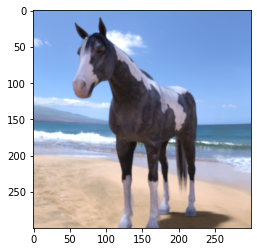


Sample human image:


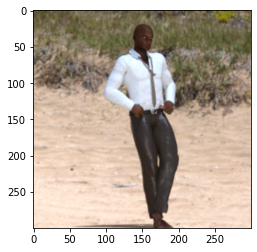

In [ ]:
print("Sample horse image:")
plt.imshow(load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}"))
plt.show()

print("\nSample human image:")
plt.imshow(load_img(f"{os.path.join(train_humans_dir, os.listdir(train_humans_dir)[0])}"))
plt.show()

`matplotlib` makes it easy to see that these images have a resolution of 300x300 and are colored, but you can double check this by using the code below:

In [ ]:
# Load the first example of a horse
sample_image  = load_img(f"{os.path.join(train_horses_dir, os.listdir(train_horses_dir)[0])}")

# Convert the image into its numpy array representation
sample_array = img_to_array(sample_image)

print(f"Each image has shape: {sample_array.shape}")

Each image has shape: (300, 300, 3)


As expected, the sample image has a resolution of 300x300 and the last dimension is used for each one of the RGB channels to represent color.

## Training and Validation Generators

In [ ]:
# GRADED FUNCTION: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class 
  # Don't forget to normalize pixel values and set arguments to augment the images 
  train_datagen = ImageDataGenerator(rescale=1./255.,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True)

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=32, 
                                                      class_mode='binary',
                                                      target_size=(150, 150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  # Remember that validation data should not be augmented
  validation_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=32, 
                                                                class_mode='binary',
                                                                target_size=(150, 150))
  ### END CODE HERE
  return train_generator, validation_generator


In [ ]:
# Test the generators
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Transfer learning - Create the pre-trained model

Download the `inception V3` weights into the `/tmp/` directory:

In [ ]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2022-04-08 11:32:05--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.107.128, 173.194.213.128, 173.194.214.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.107.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   124MB/s    in 0.7s    

2022-04-08 11:32:06 (124 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



Now load the `InceptionV3` model and save the path to the weights you just downloaded:

In [ ]:
# Import the inception model  
from tensorflow.keras.applications.inception_v3 import InceptionV3

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

Create pre_trained_model:

In [ ]:
# GRADED FUNCTION: create_pre_trained_model
def create_pre_trained_model(local_weights_file):
  ### START CODE HERE
  pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                  include_top = False, 
                                  weights = None) 

  pre_trained_model.load_weights(local_weights_file)

  # Make all the layers in the pre-trained model non-trainable
  for l in pre_trained_model.layers:
    l.trainable = False

  ### END CODE HERE

  return pre_trained_model
  

Check that everything went well by comparing the last few rows of the model summary to the expected output:

In [ ]:
pre_trained_model = create_pre_trained_model(local_weights_file)

# Print the model summary
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 74, 74, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_94 (BatchN  (None, 74, 74, 32)  96          ['conv2d_94[0][0]']              
 ormalization)                                                                                    
                                                                                       

To check that all the layers in the model were set to be non-trainable, run the cell below:

In [ ]:
total_params = pre_trained_model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in pre_trained_model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 21,802,784 total parameters in this model.
There are 0 trainable parameters in this model.


## Creating callbacks for later
the callback use to stop training once an accuracy of 99.9% is reached, is provided for you,

In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

Create output_of_last_layer with use mixed7 layer as the last layer of the pre_trained_model.


In [ ]:
# GRADED FUNCTION: output_of_last_layer
def output_of_last_layer(pre_trained_model):
  ### START CODE HERE
# last_layer = pre_trained_model.get_layer('mixed7')
# print('last layer output shape: ', last_layer.output_shape)
# last_output = last_layer.output
  
  last_desired_layer = pre_trained_model.get_layer('mixed7')
  print('last layer output shape: ', last_desired_layer.output_shape)
  last_output = last_desired_layer.output
  print('last layer output: ', last_output)
  ### END CODE HERE

  return last_output


Check that everything works as expected:

In [ ]:
last_output = output_of_last_layer(pre_trained_model)

last layer output shape:  (None, 7, 7, 768)
last layer output:  KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 768), dtype=tf.float32, name=None), name='mixed7/concat:0', description="created by layer 'mixed7'")


Now I'll create the final model by adding some additional layers on top of the pre-trained model with use Tensorflow's [Functional API](https://www.tensorflow.org/guide/keras/functional) for this since the pretrained model has been created using it. 

Let's double check this first:

In [ ]:
# Print the type of the pre-trained model
print(f"The pretrained model has type: {type(pre_trained_model)}")

The pretrained model has type: <class 'keras.engine.functional.Functional'>


To create the final model, I'll use Keras' Model class by defining the appropriate inputs and outputs as described in the first way to instantiate a Model in the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

**Note** that you can get the input from any existing model by using its `input` attribute and by using the Funcional API you can use the last layer directly as output when creating the final model.

In [ ]:
# GRADED FUNCTION: create_final_model
def create_final_model(pre_trained_model, last_output):
  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)

  ### START CODE HERE

  # Add a fully connected layer with 1024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  # Add a dropout rate of 0.2
  x = layers.Dropout(.2)(x) 
  # Add a final sigmoid layer for classification
  x = layers.Dense(1, activation='sigmoid')(x)        

  # Create the complete model by using the Model class
  model = Model(inputs=pre_trained_model.input, outputs=x)

  # Compile the model
  model.compile(optimizer = RMSprop(learning_rate=0.0001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy'])

  ### END CODE HERE
  
  return model


In [ ]:
# Save your model in a variable
model = create_final_model(pre_trained_model, last_output)

# Inspect parameters
total_params = model.count_params()
num_trainable_params = sum([w.shape.num_elements() for w in model.trainable_weights])

print(f"There are {total_params:,} total parameters in this model.")
print(f"There are {num_trainable_params:,} trainable parameters in this model.")

There are 47,512,481 total parameters in this model.
There are 38,537,217 trainable parameters in this model.


Wow, that is a lot of parameters!

After submitting your assignment later, try re-running this notebook but use the original resolution of 300x300, you will be surprised to see how many more parameters are for that case.

Now train the model:

In [ ]:
# Run this and see how many epochs it should take before the callback
# fires, and stops training at 99.9% accuracy
# (It should take a few epochs)
callbacks = myCallback()
history = model.fit(train_generator,
                    validation_data = validation_generator,
                    epochs = 100,
                    verbose = 2,
                    callbacks=callbacks)

Epoch 1/100
33/33 - 76s - loss: 0.1920 - accuracy: 0.9279 - val_loss: 0.1529 - val_accuracy: 0.9375 - 76s/epoch - 2s/step
Epoch 2/100
33/33 - 70s - loss: 0.0291 - accuracy: 0.9932 - val_loss: 0.1543 - val_accuracy: 0.9375 - 70s/epoch - 2s/step
Epoch 3/100
33/33 - 70s - loss: 0.0311 - accuracy: 0.9893 - val_loss: 0.2224 - val_accuracy: 0.9375 - 70s/epoch - 2s/step
Epoch 4/100
33/33 - 71s - loss: 0.0307 - accuracy: 0.9903 - val_loss: 0.0379 - val_accuracy: 0.9883 - 71s/epoch - 2s/step
Epoch 5/100
33/33 - 70s - loss: 0.0243 - accuracy: 0.9912 - val_loss: 0.2337 - val_accuracy: 0.9453 - 70s/epoch - 2s/step
Epoch 6/100
33/33 - 71s - loss: 0.0102 - accuracy: 0.9942 - val_loss: 0.1931 - val_accuracy: 0.9609 - 71s/epoch - 2s/step
Epoch 7/100
33/33 - 74s - loss: 0.0221 - accuracy: 0.9942 - val_loss: 0.0392 - val_accuracy: 0.9844 - 74s/epoch - 2s/step
Epoch 8/100

Reached 99.9% accuracy so cancelling training!
33/33 - 71s - loss: 7.7565e-04 - accuracy: 1.0000 - val_loss: 0.0989 - val_accuracy: 0

The training should have stopped after less than 10 epochs and it should have reached an accuracy over 99,9% (firing the callback). This happened so quickly because of the pre-trained model you used, which already contained information to classify humans from horses. Really cool!

Now take a quick look at the training and validation accuracies for each epoch of training:

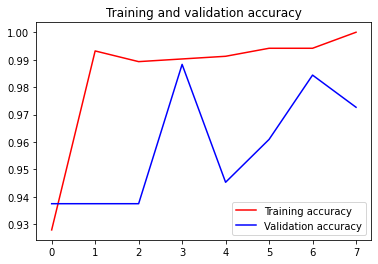

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

You will need to submit this notebook for grading. To download it, click on the `File` tab in the upper left corner of the screen then click on `Download` -> `Download .ipynb`. You can name it anything you want as long as it is a valid `.ipynb` (jupyter notebook) file.

**Congratulations on finishing this week's assignment!**

You have successfully implemented a convolutional neural network that leverages a pre-trained network to help you solve the problem of classifying humans from horses.

**Keep it up!**